In [33]:
def hw3(issuer = 'Воронежская Обл Прав', path = '', table_name = None, fig_name = None):

    # 1) Подключаемся к БД.
    import psycopg2 # драйвер для postgresql
    import getpass  # прячем параль, чтобы не писать его в параметрах

    conn=psycopg2.connect(user='postgres',
                          database='HW',
                          host='localhost',
                          port='5432',
                          password=getpass.getpass('Insert password: ')
                            )
    query = """ SELECT *
            FROM (SELECT MAX("CPN") AS "CPN", "ISIN", max("BUYBACKDATE") AS "BUYBACKDATE",
                  max("BUYBACKPRICE") AS "BUYBACKPRICE"
                  FROM public.quotes_task
                  GROUP BY "ISIN") AS cpn
            INNER JOIN(SELECT "ISINCode", "FaceValue", "HaveOffer", "AmortisedMty", 
                       "CouponPerYear", "NumCoupons", "EndMtyDate", "CouponType", "IssuerName"
                       FROM public.bond_description_task
                       WHERE "Status"!='Погашен') AS bonds
            ON cpn."ISIN" = bonds."ISINCode" """
          

    # 3) Возвращаем матрицу платежей.
    import pandas as pd

    data = pd.read_sql_query(query, conn)
    data = pd.DataFrame(data)

    data2 = data[data['IssuerName'] == issuer]
    data2 = data2[['ISIN','EndMtyDate', 'CouponType', 'CPN', 'AmortisedMty']]
    data2 = data2.sort_values(by="EndMtyDate", ascending=True)
    
    table_name = 'Выплаты_' + issuer if table_name == None else table_name
    data2.to_csv(path + table_name + '.csv')
    
    import matplotlib.pyplot as plt

    x_const = data2[data2['CouponType'] == 'Постоянный']['EndMtyDate']
    y_const = data2[data2['CouponType'] == 'Постоянный']['CPN']

    x_fixed = data2[data2['CouponType'] == 'Фиксированный']['EndMtyDate']
    y_fixed = data2[data2['CouponType'] == 'Фиксированный']['CPN']

    plt.bar(x_const, y_const, width = 10, label = 'Постоянный купон')
    plt.bar(x_fixed, y_fixed, width = 10, label = 'Фиксированный купон')
    plt.title('Купонные выплаты по облигациям ' + issuer)
    plt.legend()
    
    fig_name = 'Выплаты_' + issuer if fig_name == None else fig_name
    
    plt.savefig(path + fig_name + '.png')
    
    a = {'table': data2, 'path': path, 'figname': fig_name}
    
    return(a)

Insert password: ········


{'table':            ISIN  EndMtyDate     CouponType    CPN  AmortisedMty
 1  RU000A0JTG34  2017-12-17     Постоянный  24.56          True
 2  RU000A0JU823  2018-10-23  Фиксированный  20.64          True
 3  RU000A0JUWK6  2019-10-14     Постоянный  29.29          True,
 'path': '',
 'figname': 'Выплаты_Воронежская Обл Прав'}

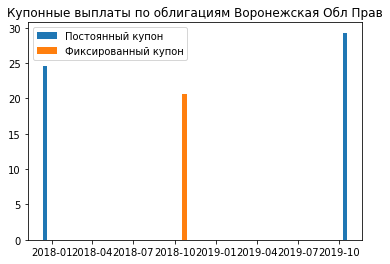

In [34]:
issuer = 'Воронежская Обл Прав'
s = hw3(issuer)
s

In [38]:
table = s['table']
path = s['path']
fig_name = s['figname']

In [42]:
# Собираем автоматический отчет в виде pdf

from __future__ import print_function
from jinja2 import Environment, FileSystemLoader
# from weasyprint import HTML, Document
import os

env = Environment(loader=FileSystemLoader('.'))
template = env.get_template("myreport.html") # Шаблон выложен в папке 111seminar на GitHub, его можно редактировать под себя
template_vars = {"title": "Отчет по" + issuer,
                "INTRO": "Отчет содержит данные по выплатам облигаций" + issuer, 
                 "TABLE_DESC": "Таблица 1. Выплаты "+issuer,
                 "TABLE": table.to_html(), 
                 "IMAGE_DESC": "Рисунок. Визуализация выплат", 
                 "IMAGE": os.path.realpath(path + fig_name + '.png')
                }
# os.path.realpath - путь к файлу относительно рабочей папки. Код выше подразумевает, что картинка хранится в рабочей папке.
# Собираем и печатаем репорт
# html_out = template.render(template_vars, presentational_hints=True)
# HTML(string=html_out).write_pdf('my_report.pdf', presentational_hints=True)
# Можно добавлять стилевые настройки, но это уже развлечение of the class.